# Классификация токсичных комментариев с использованием RNN

Сперва мы импортируем все необходимые библиотеки, определим некоторые константы и загрузим предобученные эмбеддинги.

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM,Bidirectional, GlobalMaxPool1D
import matplotlib.pyplot as plt

MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

word2vec = {}
for line in open(f'glove.6B.{EMBEDDING_DIM}d.txt', encoding='utf-8'):
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print(f'Найдено {len(word2vec)} векторных представлений.')

Using TensorFlow backend.


Найдено 400000 векторных представлений.


Теперь загрузим обучающий датасет и разделим обычные признаки от целевых. Датасет изначально очищен, поэтому никаких пропусков нет.

In [2]:
train = pd.read_csv("Toxic_comments_data/train.csv/train.csv")
sentences = train["comment_text"].values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Следующим шагом будет токенизация текстов и их паддинг, чтобы привести их к одной длине.

In [4]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

# словарь слов и их индексов
word2idx = tokenizer.word_index
print(f'Найдено {len(word2idx)} уникальных токенов.')

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('data.shape:', data.shape)

Найдено 210337 уникальных токенов.
data.shape: (159571, 100)


Нам нужно создать матрицу эмбеддингов, в которой каждой строчке будет соответствовать, загруженный ранее, предобученный вектор.

In [5]:
# 20000 слов достаточно для классификации текстов
# нам не к чему учитывать большое количество уникальных слов, что нашел токенизатор
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
      if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
          # слова, для которых не было найдено эмбеддинга, будут представлены в виде нулевого вектора
          embedding_matrix[i] = embedding_vector

Создаем модель и обучаем её.

In [6]:
# слой, проходя через который слова будут преобразовываться в эмбеддинги
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
# для предсказания используем наиболее полезный hidden state
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy'],
)

r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 120s 938us/step - loss: 0.1131 - accuracy: 0.9664 - val_loss: 0.0686 - val_accuracy: 0.9767
Epoch 2/10
127656/127656 [==============================] - 122s 956us/step - loss: 0.0639 - accuracy: 0.9781 - val_loss: 0.0613 - val_accuracy: 0.9787
Epoch 3/10
127656/127656 [==============================] - 112s 880us/step - loss: 0.0586 - accuracy: 0.9797 - val_loss: 0.0581 - val_accuracy: 0.9798
Epoch 4/10
127656/127656 [==============================] - 117s 914us/step - loss: 0.0560 - accuracy: 0.9804 - val_loss: 0.0569 - val_accuracy: 0.9798
Epoch 5/10
127656/127656 [==============================] - 129s 1ms/step - loss: 0.0543 - accuracy: 0.9809 - val_loss: 0.0550 - val_accuracy: 

Визуализируем процесс обучения.

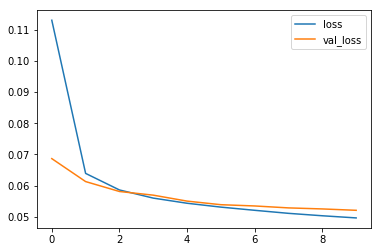

In [7]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

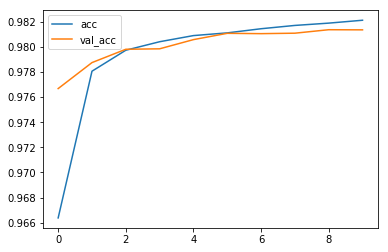

In [8]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

Загрузим тестовую выборку, сделаем на ней предсказания и оценим качество нашей модели. Нам надо будет избавиться от текстов, у которых целевой признак отображается в виде -1. Так сайт Kaggle обозначал тексты, по которым он не будет проводить проверку.

In [9]:
test = pd.read_csv("Toxic_comments_data/test.csv/test.csv")
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [10]:
test_labels = pd.read_csv("Toxic_comments_data/test_labels.csv/test_labels.csv")
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [14]:
test_labels[test_labels['toxic'] != -1].sample(20)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
16787,1c3bb7e697f34d45,0,0,0,0,0,0
65379,6ccd084d58e0db26,0,0,0,0,0,0
96915,a1b3062ae250dd51,0,0,0,0,0,0
105653,b065ddb564bd46cb,0,0,0,0,0,0
29618,3143335348c81038,0,0,0,0,0,0
54085,59e3e88e1bfd2436,0,0,0,0,0,0
11250,12e0de4f8a69de12,0,0,0,0,0,0
62988,68e61d5d65acd983,0,0,0,0,0,0
74308,7bd328a6193eda56,0,0,0,0,0,0
97968,a36d4cdf9f108248,0,0,0,0,0,0


In [15]:
idx = test_labels[test_labels['toxic'] != -1].index
test_with_answers = test.iloc[idx]
print(test_with_answers.shape)
test_with_answers.head()

(63978, 2)


,id,comment_text
5,0001ea8717f6de06,Thank you for understanding. I think very high...
7,000247e83dcc1211,:Dear god this site is horrible.
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig..."
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ..."
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l..."


Преобразуем текста в последовательности чисел. Это то, что ожидает получить на вход наша модель.

In [16]:
test_sequences = tokenizer.texts_to_sequences(test_with_answers['comment_text'])
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data

array([[    0,     0,     0, ...,   360,   175,   137],
       [    0,     0,     0, ...,   293,     8,  3327],
       [    0,     0,     0, ...,    10,     1,  1202],
       ...,
       [    0,     0,     0, ...,    14,    36, 10688],
       [    0,     0,     0, ...,   408,     5,   551],
       [    0,     0,     0, ...,     2,  1362,    11]])

In [17]:
predictions = model.predict(test_data)
predictions

array([[1.09481812e-03, 6.06477261e-05, 4.58776951e-04, 1.08122826e-04,
        3.12834978e-04, 9.88543034e-05],
       [6.31012022e-01, 4.50202823e-03, 6.67651296e-02, 9.38317180e-03,
        1.08662516e-01, 6.98107481e-03],
       [3.64420056e-01, 1.00284815e-03, 5.36550879e-02, 4.23073769e-04,
        5.56431115e-02, 5.77405095e-03],
       ...,
       [6.67648017e-01, 2.49576569e-03, 6.69763088e-02, 3.35630774e-03,
        1.66892529e-01, 4.84076738e-02],
       [9.94673908e-01, 1.65911436e-01, 9.38939929e-01, 3.93523276e-02,
        9.23169851e-01, 2.93478191e-01],
       [3.99479270e-03, 1.66773796e-04, 1.76954269e-03, 2.86340714e-04,
        1.37573481e-03, 9.58323479e-04]], dtype=float32)

В массиве предсказаний каждая строка соответствует одному тексту, а каждое число показывает вероятность принадлежности текста к соответствующему классу.

In [20]:
predictions = predictions > .5
predictions

array([[False, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [False, False, False, False, False, False],
       ...,
       [ True, False, False, False, False, False],
       [ True, False,  True, False,  True, False],
       [False, False, False, False, False, False]])

Для простоты проверим качество модели лишь на классификации одного класса - toxic.

In [24]:
test_with_answers['true_value'] = test_labels[test_labels['toxic'] != -1]['toxic']
test_with_answers['predicted_value'] = predictions[:,0].astype('int')
test_with_answers.head()

C:\Users\admin\anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\admin\anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,comment_text,true_value,predicted_value
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,1
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0


In [26]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(test_with_answers['true_value'],test_with_answers['predicted_value']))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     57888
           1       0.55      0.82      0.66      6090

    accuracy                           0.92     63978
   macro avg       0.77      0.87      0.81     63978
weighted avg       0.94      0.92      0.93     63978



Полученная модель имеет низкое значение F1-score при положительной классификации. Низкая точность означает, что модель часто классифицирует комментарии токсичными, которые на самом деле таковыми не являются.